In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pulp as lp
import itertools
import copy

In [2]:
# Offline optimal to calculate regret
def offline_optimal_action(mu):
    
    action = np.ones_like(mu[:,0]) * -1
    
    C = np.append(mu,np.zeros([mu.shape[0],1]),axis=1)
    
    num_user = mu[:,0].shape[0]
    num_server = mu[0,:].shape[0]
    
    prob = lp.LpProblem("prob",lp.LpMaximize)
    
    # Import pulp and make decision variables
    dec_var = []
    for u,s in itertools.product(range(num_user),range(num_server+1)):
        dec_var += [(u,s-1)]

    X = lp.LpVariable.dicts("x", dec_var,lowBound=0,upBound = 1, cat='Integer')

    # Make Constraints - 1 pull per user
    usr_constraint = []
    for u in range(num_user):
        usr_constraint += [0]

    for u,s in itertools.product(range(num_user),range(num_server+1)):
        usr_constraint[u] += X[(u,s-1)]

    for u in range(num_user):
        prob += (usr_constraint[u] == 1)

    # Make constraint - 1 user per server
    svr_constraint = []

    for s in range(num_server):
        svr_constraint += [0]

    for u,s in itertools.product(range(num_user),range(num_server)):
        svr_constraint[s] += X[(u,s)]

    for s in range(num_server):
        prob += (svr_constraint[s] <= 1)

    # Make objective function
    obj = 0
    for u,s in itertools.product(range(num_user),range(num_server+1)):
        obj += C[u,s-1] * X[(u,s-1)]
    prob += obj

    status = prob.solve(lp.PULP_CBC_CMD(msg=0))
    
    X2 = copy.deepcopy(X)

    for key in X2.keys():
        if X2[key].value() > 0:
            u,s = key
            action[u] = s
    
    rwd = 0
    
    for u in range(num_user):
        rwd += C[u,int(action[u])]
        
    new_action = []
    for i in range(action.shape[0]):
        new_action += [int(action[i])]
    
    return new_action, rwd

def pull_super_arm(arms, mus, rewards_record, pulls_record ):
    """
    arms - u x 1, vector, ith-element is user i, indicates which arm they will pull
    return - rewards of each arm drawn from bernoulli distribution 
    """
    
    for i in range(len(arms)): # looping through clients
        n = 1
        p = mus[i,arms[i]]
        s = np.random.binomial(n, p, 1)
        rewards_record[i,arms[i]] += [s]
        pulls_record[i,arms[i]] += 1
    return rewards_record, pulls_record
    
def update_ucb(reward_record, pulls_record, ucb, T, L=2):
    """
    Update decision variables for next round
    """
    
    num_users, num_svrs = reward_record.shape[0], reward_record.shape[1]
    for u in range(num_users):
        for s in range(num_svrs):
            if pulls_record[u,s] > 0:
                mean = reward_record[u,s]/pulls_record[u,s]
            else:
                mean = 0
            
            cb = np.sqrt(L * np.log(T)/ pulls_record[u,s])
            
            ucb[u,s] = mean + cb
    
    return ucb

    
def sweep_init_next(lst, num_svrs):
    for i in range(len(lst)):
        lst[i] += 1
        lst[i] = lst[i]%(num_svrs)
    
    return lst

def expected_reward(arms, mus):
    exp_mus = np.zeros(len(arms))
    for i in range(len(arms)):
        exp_mus[i] = mus[i, arms[i]]
        
    return np.sum(exp_mus)

In [9]:
# System Parameters
T = 10000
num_users = 10
num_svrs = 15
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])

# Recorded Values
rewards_record = np.zeros([num_users,num_svrs])
pulls_record = np.zeros([num_users,num_svrs])
ucb = np.zeros([num_users,num_svrs])
optimal = offline_optimal_action(mu)
regret = np.zeros(T)

In [10]:
# Initial Stages -- TS = servers, rotating 
arms = list(range(num_users)) 
for i in range(num_svrs):
    rewards_record, pulls_record = pull_super_arm(arms,mu, rewards_record, pulls_record)
    regret[i] = optimal[1] - expected_reward(arms, mu)
    arms = sweep_init_next(arms, num_svrs)
    
for t in range(i+1, T):
    ucb = update_ucb(rewards_record, pulls_record, ucb, i, 1)
    arms = offline_optimal_action(ucb)[0]
    rewards_record, pulls_record = pull_super_arm(arms, mu, rewards_record, pulls_record)
    regret[t] = optimal[1] - expected_reward(arms, mu)

Text(0, 0.5, 'Regret')

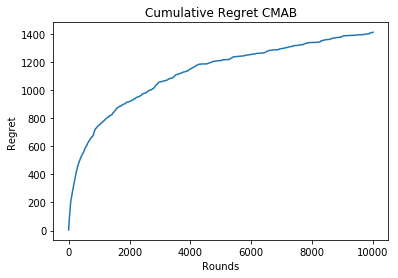

In [11]:
plt.plot(np.cumsum(regret))
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

Text(0, 0.5, 'Regret')

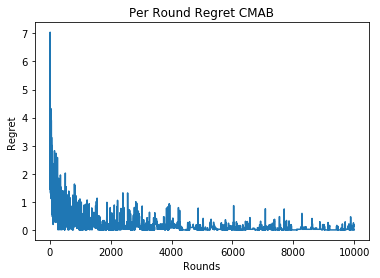

In [12]:
plt.plot(regret)
plt.title('Per Round Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

In [13]:
regret[9500:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03854173, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06190487, 0.        , 0.        , 0.06190487,
       0.        , 0.        , 0.        , 0.        , 0.06190